In [1]:
#Data Pre-Processing packages:
import numpy as np
import pandas as pd
from datetime import datetime
!pip install colorama
!pip install prophet # Prophet package should be installed with this command

#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

#NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#Time series Analysis pacakages:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Facebook Prophet packages:
from prophet import Prophet # Import from prophet, not fbprophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data = pd.read_csv('ethereum_data.csv')

In [3]:
print(f"{m_}Total records:{y_}{data.shape}\n")
print(f"{m_}Data types of data columns: \n{y_}{data.dtypes}")

Total records:(2508, 7)

Data types of data columns: 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [4]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


/var/folders/bv/g77tj00s3vg88lbmh8x8dp3h0000gn/T/ipykernel_69183/1832519430.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date'] =  pd.to_datetime(data['Date'],infer_datetime_format=True,format='%Y-%m-%d') # Changed %y to %Y to correctly parse the date


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [6]:
data.rename(columns={'Close':'Price'},inplace=True)
missing_columns = data.isnull().sum()
print(missing_columns)

Date         0
Open         0
High         0
Low          0
Price        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

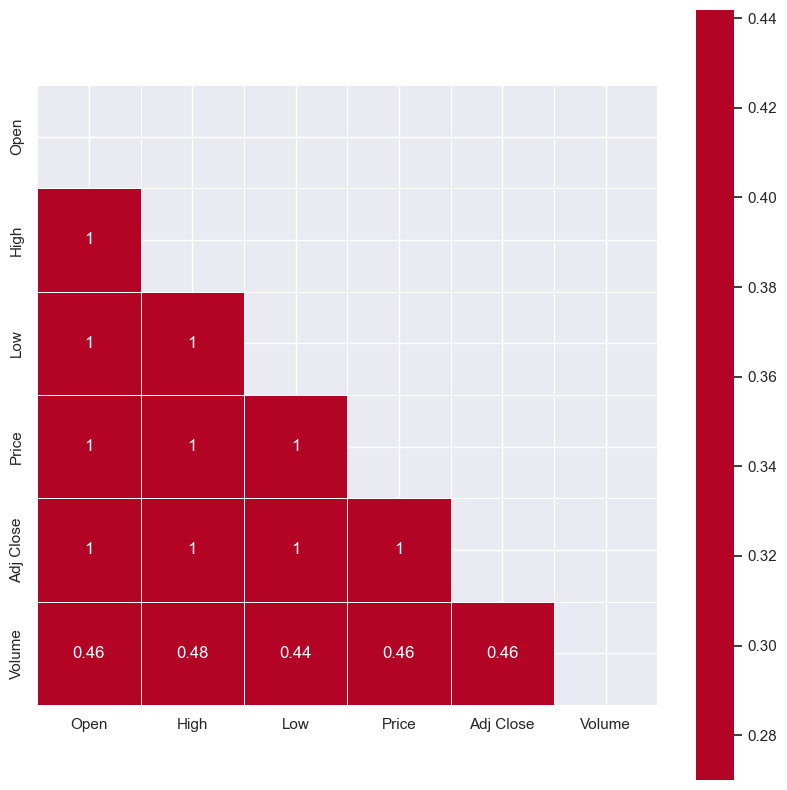

In [8]:
plt.figure(figsize=(10,10))
corr=data[data.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data[data.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

In [9]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_array(cor_matrix)

G = nx.relabel_nodes(G,lambda x: indices[x])
#G.edges(data=True)

In [10]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(H,positions,node_color='#d100d1',nodelist=nodelist,
                       node_size=tuple([x**5 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=13)
    
    if corr_direction == "positive":
        edge_colour = plt.cm.summer 
    else:
        edge_colour = plt.cm.autumn
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

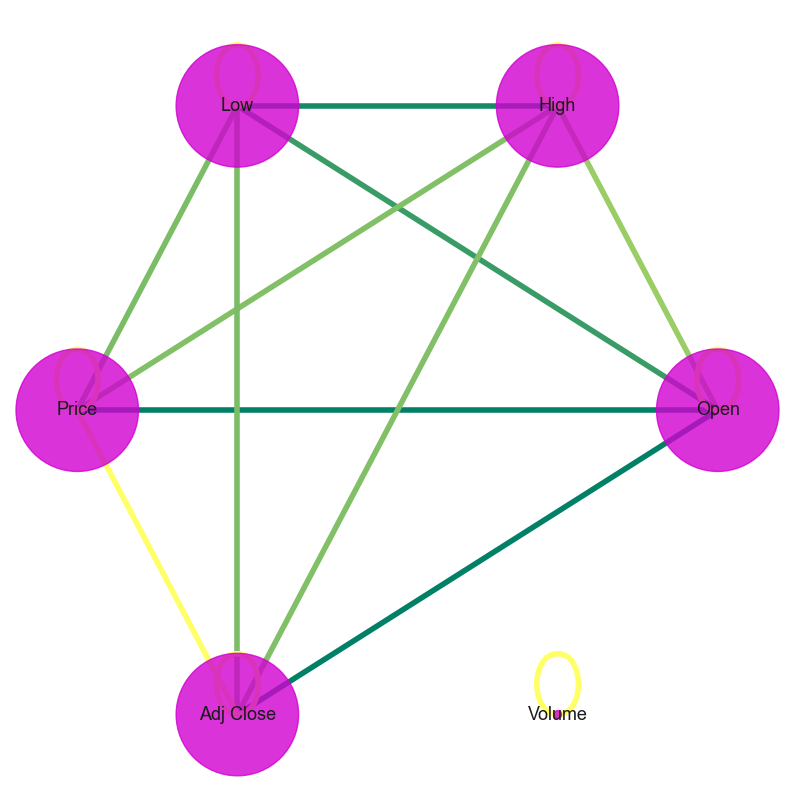

In [11]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)


In [12]:
pip install --upgrade nbformat


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip show nbformat


Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

In [14]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Price'])
                      ])
fig.show()

In [15]:
data['month']=data['Date'].dt.month
fig = go.Figure(data=[go.Candlestick(x=data['month'],
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Price'])
                      ])
fig.show()

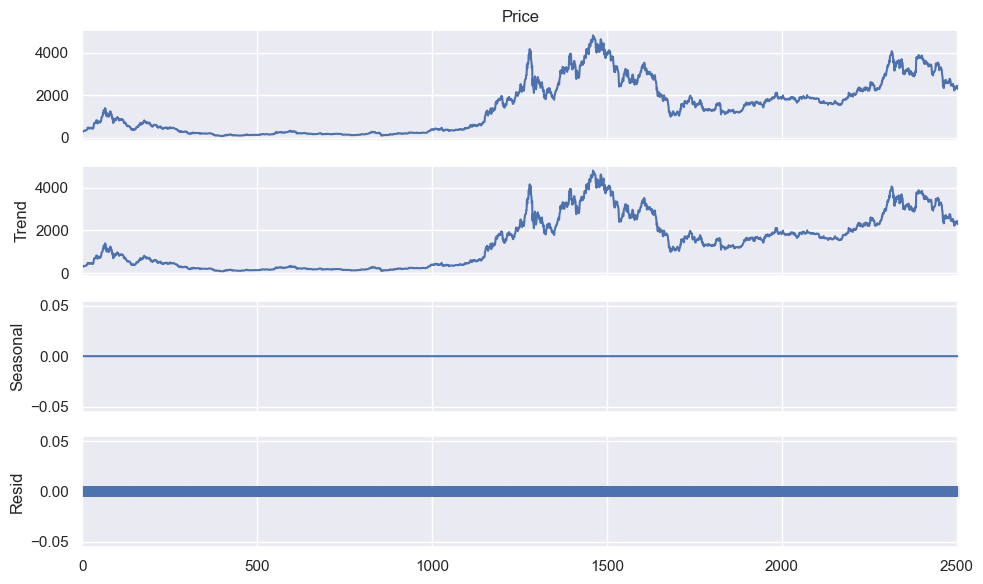

<Figure size 1500x1200 with 0 Axes>

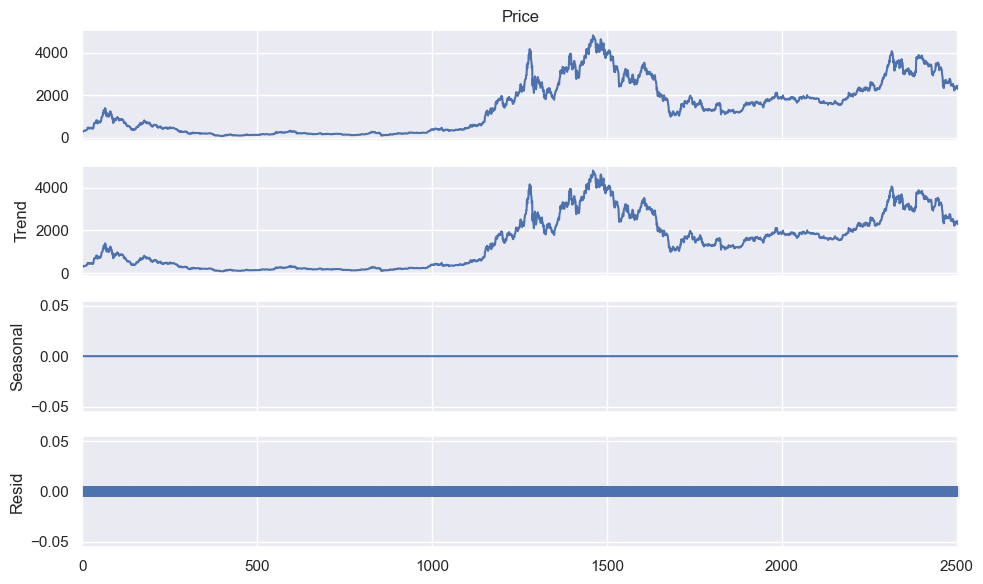

In [16]:
plt.figure(figsize=(15,12))
series = data.Price
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

In [17]:
# Renaming the column names accroding to Prophet's requirements
prophet_df=data[['Date','Price']]
prophet_df.rename(columns={'Date':'ds','Price':'y'},inplace=True)

/var/folders/bv/g77tj00s3vg88lbmh8x8dp3h0000gn/T/ipykernel_69183/1872765907.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future= prophet_basic.make_future_dataframe(periods=300)
future.tail(2)

,ds
2806,2025-07-16
2807,2025-07-17


In [20]:
forecast=prophet_basic.predict(future)


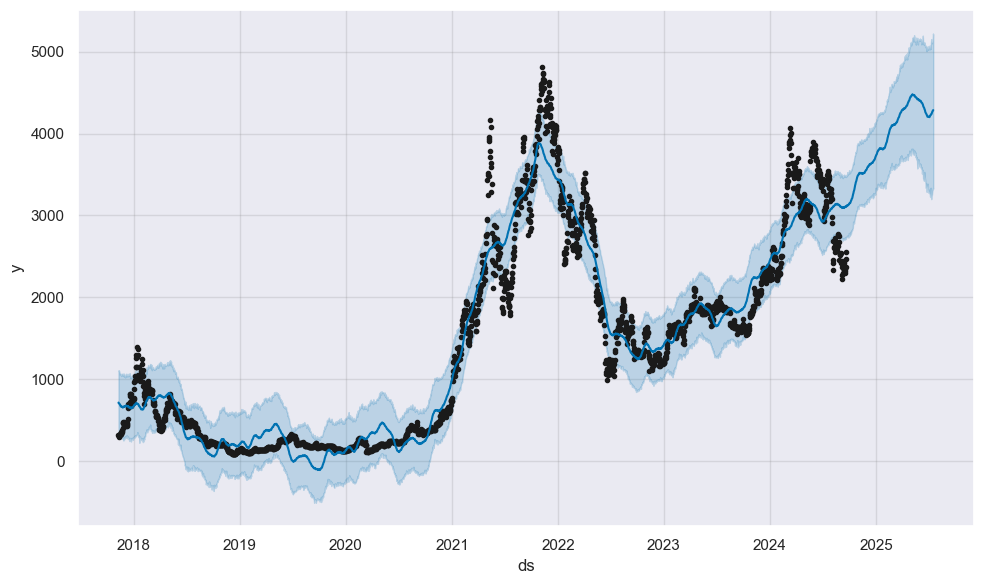

In [21]:
fig1 =prophet_basic.plot(forecast)


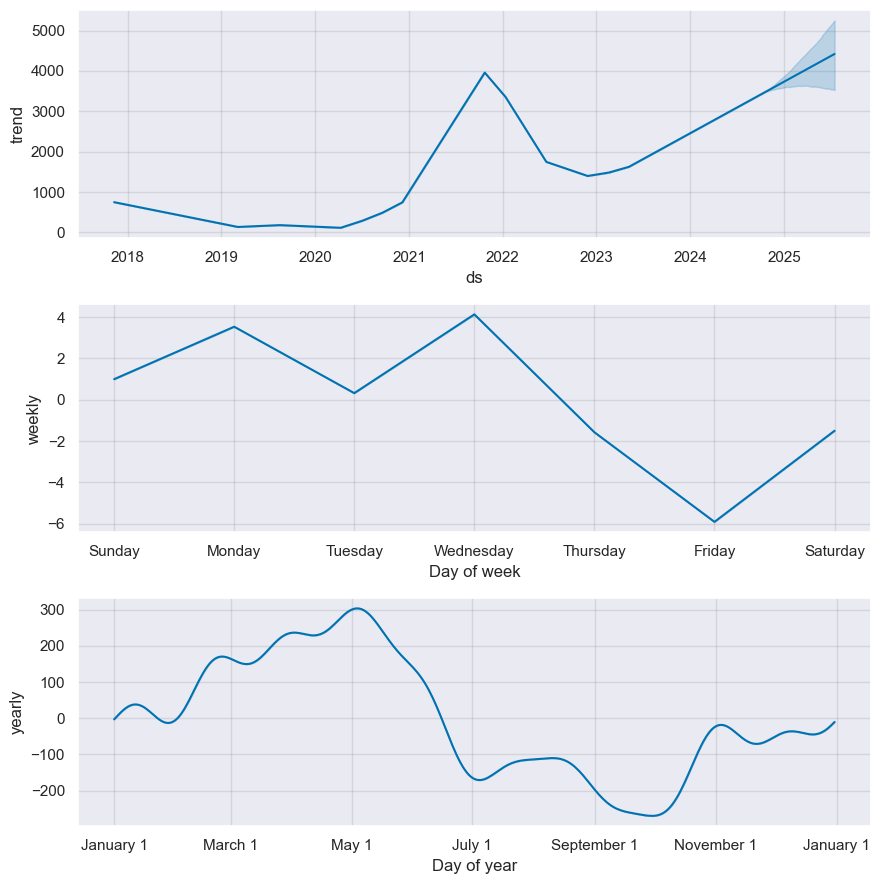

In [22]:
fig1 = prophet_basic.plot_components(forecast)


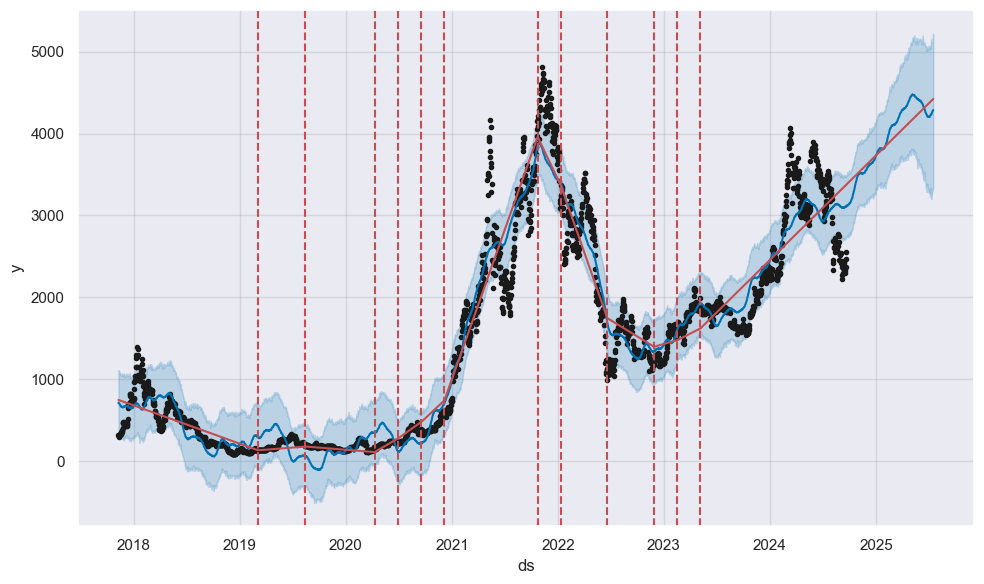

In [23]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [24]:
print(f'{m_}Change points:\n {y_}{prophet_basic.changepoints}\n')


Change points:
 80     2018-01-28
160    2018-04-18
241    2018-07-08
321    2018-09-26
401    2018-12-15
481    2019-03-05
561    2019-05-24
642    2019-08-13
722    2019-11-01
802    2020-01-20
882    2020-04-09
962    2020-06-28
1043   2020-09-17
1123   2020-12-06
1203   2021-02-24
1283   2021-05-15
1363   2021-08-03
1444   2021-10-23
1524   2022-01-11
1604   2022-04-01
1684   2022-06-20
1764   2022-09-08
1845   2022-11-28
1925   2023-02-16
2005   2023-05-07
Name: ds, dtype: datetime64[ns]



In [25]:
prophet_df['Open'] = data['Open']
prophet_df['High'] = data['High']
prophet_df['Low'] = data['Low']
prophet_df['Vol'] = data['Volume']
#prophet_df['Change'] = data['Change %']
prophet_df=prophet_df.dropna()
train_X= prophet_df[:1500]
test_X= prophet_df[1500:]


/var/folders/bv/g77tj00s3vg88lbmh8x8dp3h0000gn/T/ipykernel_69183/3444305421.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bv/g77tj00s3vg88lbmh8x8dp3h0000gn/T/ipykernel_69183/3444305421.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bv/g77tj00s3vg88lbmh8x8dp3h0000gn/T/ipykernel_69183/3444305421.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [26]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol')
#pro_regressor.add_regressor('Change')

In [27]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

18:26:45 - cmdstanpy - INFO - Chain [1] start processing
18:26:45 - cmdstanpy - INFO - Chain [1] done processing


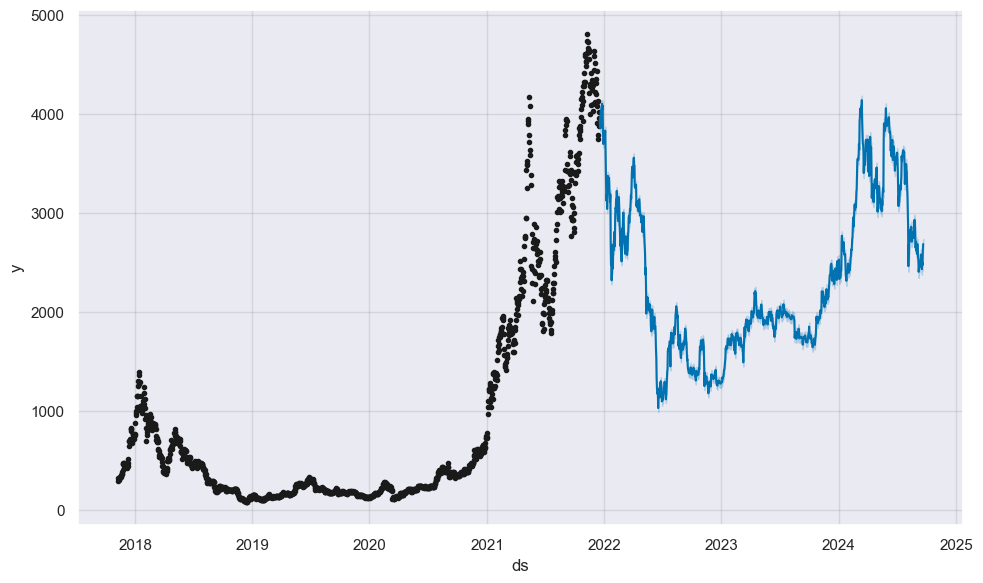

In [28]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/6 [00:00<?, ?it/s]

18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing
18:27:00 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing
18:27:00 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,196.865017,14.030859,7.807205,0.023141,0.014875,0.022810,0.890411
1,38 days,202.812155,14.241213,8.021941,0.023827,0.014875,0.023536,0.885845
2,39 days,223.268006,14.942155,8.385883,0.024710,0.015569,0.024448,0.881279
3,40 days,238.315919,15.437484,8.751978,0.025900,0.015714,0.025706,0.872146
4,41 days,242.043465,15.557746,8.935909,0.027100,0.015890,0.027019,0.869863


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,34509.211503,185.766551,132.096677,0.515123,0.052776,0.490622,0.315068
325,362 days,34205.319531,184.946802,130.695726,0.515568,0.048801,0.489625,0.319635
326,363 days,34050.848801,184.528721,130.408974,0.516003,0.052245,0.488901,0.319635
327,364 days,34014.197977,184.429385,130.117030,0.516917,0.052245,0.488602,0.324201
328,365 days,33974.369018,184.321374,130.328313,0.517461,0.052245,0.488463,0.319635


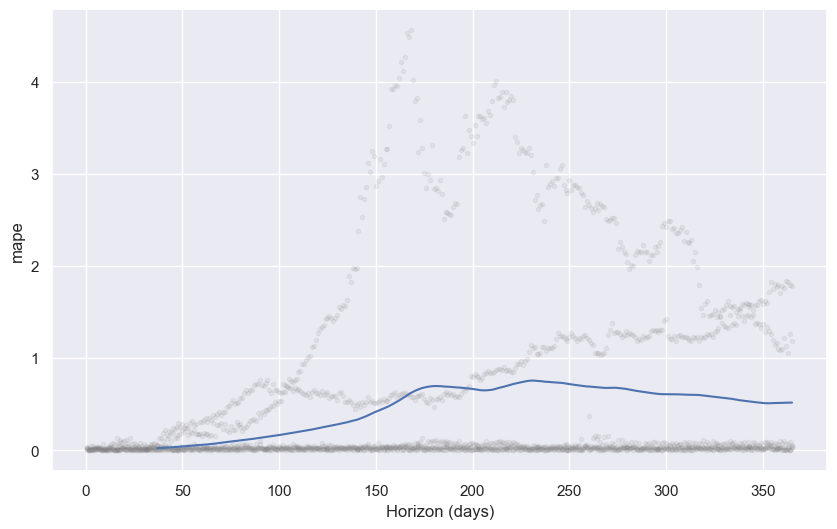

In [29]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()